# NLP Project : Disaster Tweets

This notebook will document our NLP learning process.

---

### *Goal*

**Here, we are predicting whether a given tweet is about a real disaster or not. This is a binary classification problem.**


### *Data*

- train.csv : the training set
- test.csv : the test set
- sample_submission.csv : a sample submission example


## *Columns*

* *id* : a unique identifier for each tweet
* *text* : the text of the tweet
* *location* : the location the tweet was sent from (may be blank)
* *keyword* : a particular keyword from the tweet (may be blank)
* *target* : in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

---

## References

- https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
- https://www.kaggle.com/faressayah/natural-language-processing-nlp-for-beginners
- https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook
- https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
- https://www.kaggle.com/frankmollard/nlp-a-gentle-introduction-lstm-word2vec-bert
---

## Libraries import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

import missingno as msno

from tqdm import tqdm

# Nltk libraries
import nltk
from nltk import ngrams

import re
import string

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


## Load data

 ### Train dataset

In [2]:
df_train = pd.read_csv(r'C:\Users\straw\Desktop\AIS2\DisasterTweets\Data\train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df_train.duplicated().sum()

0

### Test dataset

In [4]:
df_test = pd.read_csv(r'C:\Users\straw\Desktop\AIS2\DisasterTweets\Data\test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_test.duplicated().sum()

0

Target values are not avaible in Kaggle's test set. 

> **Gunes Evitan ([@gunesevitan](https://www.kaggle.com/gunesevitan)) wrote:**
> Test set labels can be found on [this](https://www.figure-eight.com/data-for-everyone/) website. Dataset is named **Disasters on social media**. This is how people are submitting perfect scores. Other "Getting Started" competitions also have their test labels available. The main point of "Getting Started" competitions is **learning and sharing**, and perfect score doesn't mean anything. 
> According to [@philculliton](https://www.kaggle.com/philculliton) from Kaggle Team, competitors who use test set labels in any way are not eligible to win AutoML prize. There are no other penalties for using them.


In [6]:
df_leak = pd.read_csv(r'C:\Users\straw\Desktop\AIS2\DisasterTweets\Data\socialmedia-disaster-tweets-DFE.csv', encoding ='ISO-8859-1')[["choose_one", "text"]]

df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak.drop(columns=['choose_one'], inplace=True)

df_test = df_test.merge(df_leak, on=['text'])
df_test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [7]:
df_train.location = df_train.location.fillna('unknown-location')
df_train.keyword = df_train.keyword.fillna('Unknown-keyword')
df_test.location = df_test.location.fillna('unknown-location')
df_test.keyword = df_test.keyword.fillna('Unknown-keyword')

In [8]:
def remove_stopwords(sent):
    stopW = nltk.corpus.stopwords.words('english')
    stopW.extend(list(string.punctuation))
    return [word for word in sent if word not in stopW]

def lemmatize(sent, join=False):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(w,'v'),'n'),'a') for w in sent]
    if join:
        return ' '.join(tokens)
    else:
        return tokens
    
def remove_digits(sent):
    return [word for word in sent if not re.match(r"\S*\d+\S*", word)]

def remove_single_letters(sent):
    return [word for word in sent if len(word) > 1]

def remove_noise(sent):
    typos = ["û_", "amp", "ûª", "http", "https", "co", "rt", 
             "ûªs", "@", "...", "ûªs", "ûò", "åè", "ìñ1"]
    return [word for word in sent if word not in typos]

def join_tweets(sent):
    return "  ".join(sent)

def preprocess(df):
    # Normalize
    df['text_cleaned'] = df['text'].apply(lambda sent: sent.lower())
    
    # Tokenize
    token = nltk.tokenize.RegexpTokenizer(r"\w+")
    df['text_cleaned'] = df['text_cleaned'].apply(token.tokenize)
    
    # New column : tweet lengths before cleaning
    df['text_length_before'] = df.text_cleaned.apply(len)
    
    # Remove stopwords and punctuation
    df['text_cleaned'] = df['text_cleaned'].apply(lambda sent: remove_stopwords(sent)).reset_index(drop=True)
    
    # Lemmatize
    df['text_cleaned'] = df['text_cleaned'].apply(lambda sent: lemmatize(sent))
    
    # Remove digits
    df['text_cleaned'] = df['text_cleaned'].apply(remove_digits).reset_index(drop=True)
    
    # Remove single letter
    df['text_cleaned'] = df['text_cleaned'].apply(remove_single_letters).reset_index(drop=True)
    
    # Remove weird symbols
    df['text_cleaned'] = df['text_cleaned'].apply(remove_noise).reset_index(drop=True)
    
    # New column : tweet lengths after cleaning
    df['text_length_after'] = df.text_cleaned.apply(len)
    
    # Join words into one str
    df['text_cleaned'] = df['text_cleaned'].apply(join_tweets)
    
    return df

In [9]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

## Wordcloud

In [76]:
train_1 = df_train[df_train['target']==1].reset_index(drop=True)
train_0 = df_train[df_train['target']==0].reset_index(drop=True)
test_1 = df_test[df_test['target']==1].reset_index(drop=True)
test_0 = df_test[df_test['target']==0].reset_index(drop=True)

In [221]:
texts_train_1 = []
for i in range(0, train_1.shape[0]):
    texts_train_1.append(train_1['text_cleaned'][i])
wordcloud1 = WordCloud(background_color='white', colormap="hot").generate(" ".join(texts_train_1))

In [243]:
texts_train_0 = []
for i in range(0, train_0.shape[0]):
    texts_train_0.append(train_0['text_cleaned'][i])
wordcloud2 = WordCloud(background_color='white', colormap="cividis").generate(" ".join(texts_train_0))

In [216]:
texts_test_1 = []
for i in range(0, test_1.shape[0]):
    texts_test_1.append(test_1['text_cleaned'][i])
wordcloud3 = WordCloud(background_color='white', colormap="hot").generate(" ".join(texts_test_1))

In [244]:
texts_test_0 = []
for i in range(0, test_0.shape[0]):
    texts_test_0.append(test_0['text_cleaned'][i])
wordcloud4 = WordCloud(background_color='white', colormap="cividis").generate(" ".join(texts_test_0))

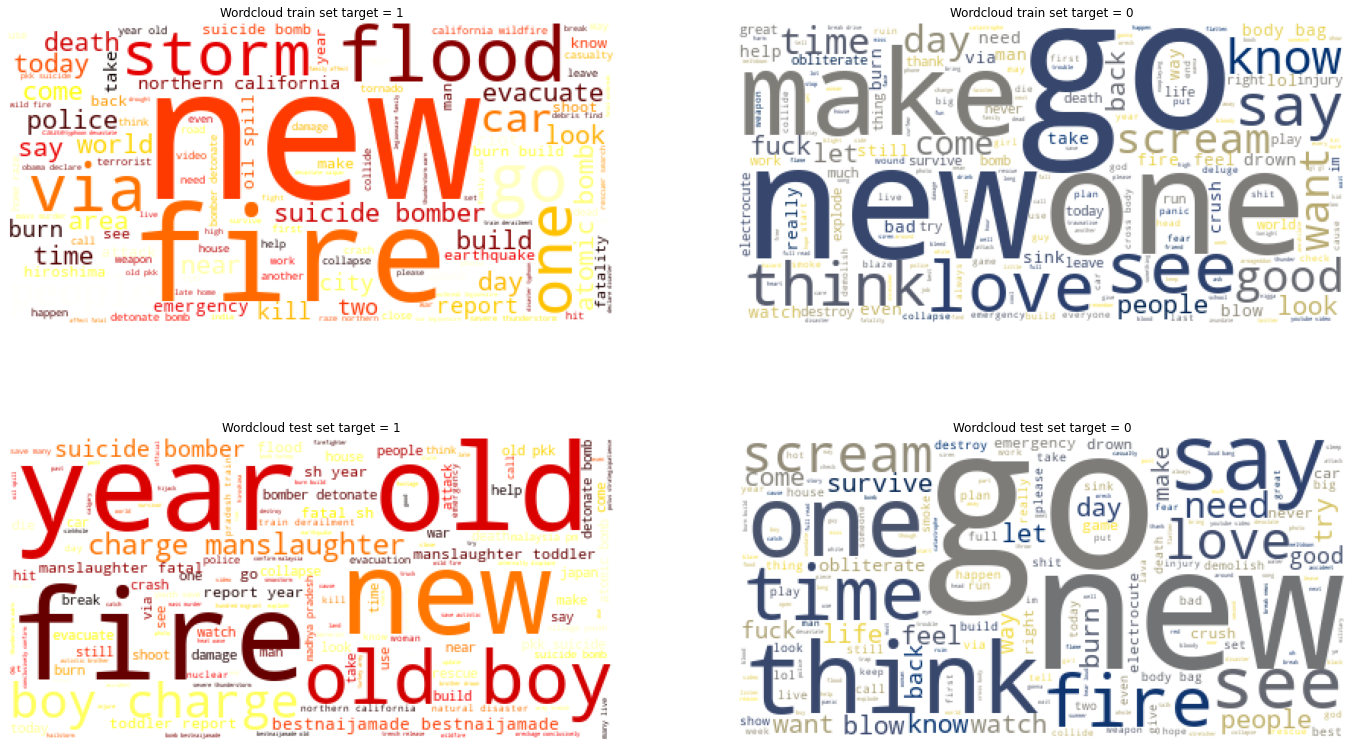

In [246]:
plt.subplots(figsize = (24, 14))

plt.subplot(2,2,1)
plt.imshow(wordcloud1)
plt.axis('off')
plt.title("Wordcloud train set target = 1")

plt.subplot(2,2,2)
plt.imshow(wordcloud2)
plt.axis('off')
plt.title("Wordcloud train set target = 0")

plt.subplot(2,2,3)
plt.imshow(wordcloud3)
plt.axis('off')
plt.title("Wordcloud test set target = 1")

plt.subplot(2,2,4)
plt.imshow(wordcloud4)
plt.axis('off')
plt.title("Wordcloud test set target = 0")

plt.show()

## Splitting data

In [11]:
X = np.array(df_train.text_cleaned)
y = np.array(df_train.target)

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.25)

In [12]:
X_test = np.array(df_test.text_cleaned)
y_test = np.array(df_test.target)

## Vectorization

In [13]:
vect = CountVectorizer()

vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_val_dtm = vect.transform(X_val)
X_test_dtm = vect.transform(X_test)

In [14]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit_transform(X_train_dtm)
tfidf_transformer.transform(X_val_dtm)
tfidf_transformer.transform(X_test_dtm)

<3477x11576 sparse matrix of type '<class 'numpy.float64'>'
	with 26052 stored elements in Compressed Sparse Row format>

## Classification with Machine Learning

In [89]:
from xgboost import XGBClassifier

In [344]:
clf = XGBClassifier(n_estimators=400, use_label_encoder=False)

In [345]:
%time clf.fit(X_train_dtm, y_train)

[22:06:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1.35 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Validation set

In [346]:
%time y_pred_val = clf.predict(X_val_dtm)

Wall time: 18.9 ms


In [347]:
accuracy_score(y_val, y_pred_val)

0.7778361344537815

In [348]:
f1_score(y_val, y_pred_val)

0.7279742765273313

<AxesSubplot:>

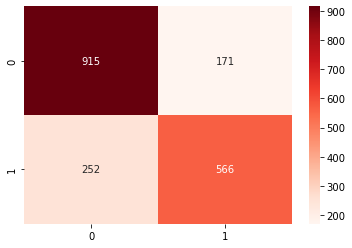

In [349]:
sns.heatmap(confusion_matrix(y_val, y_pred_val), annot=True, fmt='.4g', cmap='Reds')

In [350]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1086
           1       0.77      0.69      0.73       818

    accuracy                           0.78      1904
   macro avg       0.78      0.77      0.77      1904
weighted avg       0.78      0.78      0.78      1904



### Test set

In [361]:
%time y_pred_test = clf.predict(X_test_dtm)

Wall time: 29.9 ms


In [352]:
accuracy_score(y_test, y_pred_test)

0.7911993097497843

In [353]:
f1_score(y_test, y_pred_test)

0.7518796992481203

<AxesSubplot:>

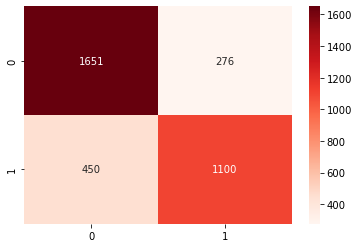

In [354]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.4g', cmap='Reds')

In [321]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1927
           1       0.80      0.71      0.75      1550

    accuracy                           0.79      3477
   macro avg       0.79      0.78      0.79      3477
weighted avg       0.79      0.79      0.79      3477



# Bert

In [27]:
pip install bert-tensorflow==1.0.1

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

from bert import tokenization

In [29]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [30]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [31]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [32]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

AttributeError: module 'tensorflow' has no attribute 'gfile'

In [ ]:
train_input = bert_encode(df_train.text.values, tokenizer, max_len=160)
test_input = bert_encode(df_test.text.values, tokenizer, max_len=160)
train_labels = df_train.target.values

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)